<a href="https://colab.research.google.com/github/lizagonch/NLP/blob/master/sem12_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Active Learning

Активное обучение $-$ класс алгоритмов обучения моделей машинного обучения. Алгоритмы активного обучения отличаются тем, могут интерактивно запрашивать пользователя (или некоторый другой источник информации) для разметки новых примеров данных.

<img src="active_learning.png">

## Active Learning Strategies

#### Pool-Based Sampling

В этом сценарии экземпляры извлекаются из всего пула данных и им присваивается информативная оценка, которая показывает, насколько хорошо текущий алгоритм «понимает» данные. 

Затем система выбираются и размечаются наиболее информативные примеры.

#### Uncertainty sampling


В рамках этого алгоритма размечаются те примеры, на которых текущая модель наименее уверена.

В качестве функций "уверенности" можно использовать вероятности классов или расстояния до разделяющей гиперплоскости.

#### Membership Query Synthesis

Здесь алгритм обучения модели генерирует свои собственные примеры из некоторого настраиваемого распределения. 
Эти сгенерированные примеры отправляются на разметку и модель дообучается с учетом разметки этих примеров.

#### Query by Committee

Идея: построить ансамбль моделей $a_1,...,a_T$. 

Выбирать новые объекты $x_i$ с наибольшей несогласованностью решений ансамбля моделей.



Принцип максимума энтропии: выбираем $x_i$, на котором $a_t(x_i)$ максимально различны.

Принцип максимума средней $KL$-дивергенции:выбираем $x_i$ , на котором $P_t(y|x_i)$ максимально различны:

$С(y|u) = \frac{1}{T}\sum_{t=1}^T P_t(y|u)$ - консенсус комитета 

## SVM для Active Learning

Некоторые активные алгоритмы обучения построены на алгоритме SVM и используют структуру SVM для определения того, какие точки данных нужно размечать. 

SVM используется для определения уверенности модели в предсказании на каждом из примеров выборки. 
В качестве меры уверенности служит расстояние от объекта до построенной не текущей итерации разделяющей гиперплоскости.

## Active Learning for texts classification

Рассмотрим алгоритм pool-based active learning на примере задачи классификации твитов по тональности.


1. Разделить данные на X_pool (выборка, которую можно размечать) и X_test.
2. Выбрать $k$ примеров из X_pool для начального X_train и разметить их. Остальные данные в X_pool $-$ валидационное множество. 
3. Обучить модель на  X_train.
5. Сделать predict обученной моделью на X_pool, вычислить вероятности для каждого $x_i$.
6. Вычислить качество работы модели на X_test.
7. Выбрать $k$ наиболее информативных объектов из X_pool, основываясь на уверенности модели в каждом из объектов (например, вероятности классов).
8. Переменести эти $k$ выбранных объектов в X_train.
9. Если качество работы модели на X_test достаточное, то останавливаемся, иначе возвращаемся к шагу 3.

In [0]:
from sklearn.metrics import f1_score

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk import ngrams

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
! wget https://raw.githubusercontent.com/PragmaticsLab/NLP-course-AMI/dev/seminars/sem12_active_learning/spam_text_classification_data.csv

--2019-11-27 05:07:36--  https://raw.githubusercontent.com/PragmaticsLab/NLP-course-AMI/dev/seminars/sem12_active_learning/spam_text_classification_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485702 (474K) [text/plain]
Saving to: ‘spam_text_classification_data.csv’

spam_text_classific 100%[===================>] 474.32K  --.-KB/s    in 0.06s   

2019-11-27 05:07:41 (7.61 MB/s) - ‘spam_text_classification_data.csv’ saved [485702/485702]



In [4]:
df = pd.read_csv('spam_text_classification_data.csv')
print(df.shape)
df.head()

(5572, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
df['label'] = [0 if category == 'ham' else 1 for category in df['Category']]

In [0]:
X,X_test,y,y_test = train_test_split(np.array(df['Message']), np.array(df['label']))

In [0]:
def get_confidence(class_probs):
    return abs(0.5-class_probs[0])

In [0]:
train_size = 50

dataset_size = X.shape[0]
target_score = 0.95
score = 0
step = 10

X_train = X[:train_size]
y_train = y[:train_size]
X_pool = X[train_size:]
y_pool = y[train_size:]

scores = [0]
train_szs = [0]

while score < target_score and train_size <= dataset_size:
    vec = CountVectorizer(ngram_range=(1, 1))
    bow = vec.fit_transform(X_train)
    clf = LogisticRegression()
    clf = clf.fit(bow,y_train)
    pred = clf.predict(vec.transform(X_test))
    
    print("{0} train samples".format(train_size))
    print(classification_report(pred, y_test))
    score = f1_score(pred, y_test)
    scores.append(score)
    train_szs.append(train_size)
    
    pred_probs = clf.predict_proba(vec.transform(X_pool))
    confidences = [get_confidence(probs) for probs in pred_probs]
    
    X_train = np.concatenate([X_train, X_pool[np.argsort(confidences)[:step]]])
    y_train = np.concatenate([y_train, y_pool[np.argsort(confidences)[:step]]])
    X_pool = X_pool[sorted(np.argsort(confidences)[step:])]
    y_pool = y_pool[sorted(np.argsort(confidences)[step:])]
    train_size += step

In [22]:
train_size = 50

dataset_size = X.shape[0]
target_score = 0.95
score = 0
step = 10

X_train = X[:train_size]
y_train = y[:train_size]
X_pool = X[train_size:]
y_pool = y[train_size:]

scores = [0]
train_szs = [0]

while score < target_score and train_size <= dataset_size:
    vec = CountVectorizer(ngram_range=(1, 1))
    bow = vec.fit_transform(X_train)
    clf = LogisticRegression()
    clf = clf.fit(bow,y_train)
    pred = clf.predict(vec.transform(X_test))
    
    print("{0} train samples".format(train_size))
    print(classification_report(pred, y_test))
    score = f1_score(pred, y_test)
    scores.append(score)
    train_szs.append(train_size)
    
    pred_probs = clf.predict_proba(vec.transform(X_pool))
    #confidences = [get_confidence(probs) for probs in pred_probs]
    e = (-pred_probs * np.log2(pred_probs)).sum(axis=1)
    print (e)
    
    X_train = np.concatenate([X_train, X_pool[np.argsort(e)[::-1][:step]]])
    y_train = np.concatenate([y_train, y_pool[np.argsort(e)[::-1][:step]]])
    X_pool = X_pool[sorted(np.argsort(e)[::-1][step:])]
    y_pool = y_pool[sorted(np.argsort(e)[::-1][step:])]
    train_size += step

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


50 train samples
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      1392
           1       0.01      1.00      0.01         1

    accuracy                           0.88      1393
   macro avg       0.50      0.94      0.47      1393
weighted avg       1.00      0.88      0.93      1393

[0.1581867  0.46981259 0.37086783 ... 0.45746971 0.50768414 0.43528067]
60 train samples
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1378
           1       0.09      1.00      0.16        15

    accuracy                           0.89      1393
   macro avg       0.54      0.94      0.55      1393
weighted avg       0.99      0.89      0.93      1393

[0.15410785 0.48566504 0.36322672 ... 0.45717283 0.54895692 0.5198989 ]
70 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1344
           1       0.27      0.96      0.4

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


100 train samples
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1266
           1       0.65      0.89      0.75       127

    accuracy                           0.95      1393
   macro avg       0.82      0.92      0.86      1393
weighted avg       0.96      0.95      0.95      1393

[0.09863605 0.56306073 0.39684579 ... 0.55531347 0.76725327 0.8118951 ]
110 train samples
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1252
           1       0.71      0.88      0.78       141

    accuracy                           0.95      1393
   macro avg       0.85      0.92      0.88      1393
weighted avg       0.96      0.95      0.95      1393

[0.08389759 0.5289699  0.39953238 ... 0.48654647 0.75506665 0.86686542]
120 train samples
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1251
           1       0.73      0.90      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.08581144 0.5565315  0.41415954 ... 0.50471723 0.74377006 0.9469874 ]
130 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1245
           1       0.75      0.89      0.82       148

    accuracy                           0.96      1393
   macro avg       0.87      0.93      0.90      1393
weighted avg       0.96      0.96      0.96      1393

[0.11167343 0.59264863 0.47099395 ... 0.55547788 0.75190693 0.93505338]
140 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1248
           1       0.77      0.93      0.84       145

    accuracy                           0.96      1393
   macro avg       0.88      0.95      0.91      1393
weighted avg       0.97      0.96      0.97      1393

[0.15481753 0.68593766 0.53166708 ... 0.53010975 0.77342824 0.94405272]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


150 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1249
           1       0.77      0.94      0.85       144

    accuracy                           0.96      1393
   macro avg       0.88      0.95      0.91      1393
weighted avg       0.97      0.96      0.97      1393

[0.1431578  0.72970354 0.51222891 ... 0.67532038 0.71181661 0.9122718 ]
160 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1241
           1       0.81      0.93      0.87       152

    accuracy                           0.97      1393
   macro avg       0.90      0.95      0.93      1393
weighted avg       0.97      0.97      0.97      1393

[0.18120836 0.71117919 0.50550994 ... 0.69061649 0.73450328 0.93876992]
170 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1238
           1       0.81      0.91      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.16984828 0.72448443 0.54128205 ... 0.67455187 0.72872551 0.95906718]
180 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1247
           1       0.79      0.95      0.87       146

    accuracy                           0.97      1393
   macro avg       0.89      0.96      0.92      1393
weighted avg       0.97      0.97      0.97      1393

[0.15366505 0.65289053 0.5184381  ... 0.5607818  0.69262093 0.90906155]
190 train samples
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1235
           1       0.82      0.91      0.86       158

    accuracy                           0.97      1393
   macro avg       0.91      0.94      0.92      1393
weighted avg       0.97      0.97      0.97      1393

[0.14438143 0.70210698 0.56335217 ... 0.58649623 0.7009999  0.9414999 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


200 train samples
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1233
           1       0.85      0.93      0.88       160

    accuracy                           0.97      1393
   macro avg       0.92      0.95      0.93      1393
weighted avg       0.97      0.97      0.97      1393

[0.15275506 0.63475556 0.51743299 ... 0.55261909 0.6845116  0.88561946]
210 train samples
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1236
           1       0.84      0.94      0.89       157

    accuracy                           0.97      1393
   macro avg       0.92      0.96      0.94      1393
weighted avg       0.97      0.97      0.97      1393

[0.14116798 0.63937491 0.54091559 ... 0.50989221 0.63031739 0.9050245 ]
220 train samples
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1239
           1       0.84      0.95      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


250 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1234
           1       0.87      0.96      0.92       159

    accuracy                           0.98      1393
   macro avg       0.93      0.97      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.09419883 0.53087853 0.52128775 ... 0.51049066 0.57437708 0.80426266]
260 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1232
           1       0.89      0.96      0.92       161

    accuracy                           0.98      1393
   macro avg       0.94      0.97      0.96      1393
weighted avg       0.98      0.98      0.98      1393

[0.10412802 0.50401332 0.62152487 ... 0.53929042 0.6003379  0.72931711]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


270 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1235
           1       0.87      0.96      0.91       158

    accuracy                           0.98      1393
   macro avg       0.93      0.97      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.08746088 0.48788638 0.57606468 ... 0.53666858 0.57678235 0.71985453]
280 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1238
           1       0.86      0.97      0.91       155

    accuracy                           0.98      1393
   macro avg       0.93      0.97      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.1220363  0.45293357 0.55628566 ... 0.50065949 0.58896754 0.62164151]
290 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1237
           1       0.86      0.97      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.12942702 0.43977949 0.48778389 ... 0.52158193 0.59237234 0.61081484]
300 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.13171794 0.39407452 0.4589357  ... 0.54173265 0.60054422 0.62677059]
310 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.85      0.98      0.91       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.11990764 0.38393084 0.478043   ... 0.5044477  0.58759269 0.63200118]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


320 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.97      0.91       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.10333294 0.40610443 0.42628484 ... 0.48470347 0.57363875 0.65043483]
330 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1237
           1       0.87      0.97      0.92       156

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.09779156 0.39943327 0.42954872 ... 0.51283768 0.58043265 0.66849824]
340 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


370 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.85      0.99      0.91       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.07055378 0.30888968 0.33473232 ... 0.38459956 0.48181202 0.63167715]
380 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1243
           1       0.85      0.99      0.91       150

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.06841062 0.29735228 0.34196982 ... 0.36539846 0.47308545 0.6190493 ]
390 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1243
           1       0.85      0.99      0.91       150

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.07963468 0.29928039 0.33310015 ... 0.35599463 0.44934557 0.57152982]
400 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.85      0.99      0.91       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.08617459 0.3116363  0.33751151 ... 0.35416994 0.42956185 0.63384953]
410 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.85      0.98      0.91       151

  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.07395867 0.31198723 0.34102973 ... 0.32674269 0.42395913 0.58159985]
420 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.98      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.07362354 0.27760626 0.3246465  ... 0.32118018 0.42593777 0.58711416]
430 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.07491662 0.27947987 0.32751337 ... 0.32664853 0.40145386 0.5830016 ]
440 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.98      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.06401443 0.24634924 0.30909555 ... 0.30314349 0.39459276 0.54509857]
450 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.06089805 0.24704501 0.29647075 ... 0.30290357 0.33056802 0.55173147]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


460 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.05059123 0.24340728 0.29351864 ... 0.27657566 0.32571688 0.54249398]
470 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.05237123 0.23153842 0.28128268 ... 0.2648954  0.31393817 0.5440296 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


480 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.05349162 0.26131822 0.26903596 ... 0.25596849 0.31629539 0.5124251 ]
490 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.04762712 0.25962775 0.27012924 ... 0.23335816 0.31022046 0.50375025]
500 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


530 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03588357 0.21909935 0.22222931 ... 0.22099034 0.26981732 0.4630645 ]
540 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03866327 0.21677391 0.21801778 ... 0.21855925 0.26447136 0.46801607]
550 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.04261502 0.20469354 0.2099842  ... 0.20905473 0.26416068 0.46336024]
560 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.04224229 0.1960232  0.20615199 ... 0.198374   0.25986331 0.45490894]
570 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03834208 0.19032426 0.20226099 ... 0.17937636 0.19094293 0.24721119]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


580 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03589126 0.19621576 0.20088113 ... 0.18124935 0.19273791 0.23190818]
590 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03665781 0.18144247 0.19483681 ... 0.18284809 0.18853252 0.22796235]
600 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03628902 0.17849478 0.18795349 ... 0.17442554 0.18033905 0.22566601]
610 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03840199 0.19199372 0.17634924 ... 0.16512023 0.1738746  0.24604971]
620 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.03299768 0.17987673 0.15418203 ... 0.14659468 0.16387082 0.23841815]
650 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02999267 0.17110682 0.15588588 ... 0.15129663 0.17113192 0.22511846]
660 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.03233187 0.17834826 0.15618452 ... 0.16311444 0.17497947 0.21551161]
670 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02855848 0.17306022 0.14626195 ... 0.16294829 0.1640566  0.21600108]
680 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.02816454 0.16790053 0.14413457 ... 0.15490127 0.15332714 0.21062925]
690 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02466616 0.16806748 0.14367715 ... 0.134142   0.15348806 0.20644763]
700 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0254693  0.15954903 0.14474492 ... 0.12964639 0.14814877 0.20433512]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


710 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02564459 0.15967686 0.14363837 ... 0.12850423 0.14757209 0.19565763]
720 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02404959 0.15610104 0.14140858 ... 0.12250148 0.14395972 0.19588588]
730 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.02375026 0.15131569 0.13812848 ... 0.12110497 0.14325848 0.188528  ]
740 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.86      0.98      0.91       153

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02347608 0.14846585 0.1345765  ... 0.11982417 0.13997705 0.18617802]
750 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.97      0.91       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02798466 0.14954336 0.12380906 ... 0.1138973  0.14224339 0.17238397]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


760 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03527486 0.1446185  0.12466081 ... 0.11188982 0.15371011 0.1674238 ]
770 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1238
           1       0.86      0.97      0.92       155

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03470999 0.13789824 0.12553979 ... 0.10906524 0.14844368 0.165131  ]
780 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1238
           1       0.86      0.97      0.92       155

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0344285  0.13812447 0.12156208 ... 0.10774924 0.14806996 0.16478065]
790 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1238
           1       0.86      0.97      0.92       155

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.03171777 0.13639986 0.12144835 ... 0.10796035 0.14930299 0.16314614]
800 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.98      0.92       154

  

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.02724037 0.12970505 0.11751066 ... 0.10432865 0.1374192  0.15197062]
830 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.97      0.91       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.027659   0.12947157 0.11733758 ... 0.10135961 0.13450169 0.15102359]
840 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1239
           1       0.86      0.97      0.91       154

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02624085 0.12431508 0.1166907  ... 0.09672592 0.13510212 0.1500841 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

850 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.98      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02401377 0.12005334 0.11629469 ... 0.09951398 0.1396971  0.1426404 ]
860 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02344267 0.11886465 0.1133054  ... 0.09714863 0.13573926 0.143509  ]
870 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02243201 0.11135741 0.10960516 ... 0.09203289 0.12665147 0.13866336]
900 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.02197627 0.10913678 0.10817232 ... 0.09160145 0.1245148  0.137903  ]
910 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01920422 0.10074434 0.10768538 ... 0.0885746  0.13127675 0.13685784]
920 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01928252 0.09735181 0.10387178 ... 0.09038171 0.13799508 0.13479935]
930 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01797083 0.09611291 0.10263487 ... 0.08715183 0.12947674 0.13610058]
940 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0176482  0.09355083 0.10060151 ... 0.08706688 0.12802754 0.13288659]
950 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01720555 0.09279203 0.10007834 ... 0.0847734  0.12361462 0.13079009]
960 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01685945 0.09284991 0.09792798 ... 0.08464782 0.1235061  0.1299445 ]
970 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01674602 0.09285984 0.09778344 ... 0.08172767 0.12066691 0.12863971]
980 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01608101 0.09356682 0.0957292  ... 0.07984214 0.11985001 0.12994467]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


990 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01594856 0.09162264 0.09437243 ... 0.07934839 0.11804981 0.12324107]
1000 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01580896 0.09228073 0.09379025 ... 0.08001491 0.11736093 0.12301883]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1010 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01451618 0.09241128 0.09385606 ... 0.07324927 0.11619086 0.12183146]
1020 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01413437 0.09174296 0.09317163 ... 0.07244262 0.11512277 0.12055963]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1030 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01395158 0.09014759 0.09154538 ... 0.07203965 0.11423339 0.11676373]
1040 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01378055 0.08923979 0.09035165 ... 0.07140128 0.11359745 0.1159808 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1050 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01430097 0.0887462  0.08911339 ... 0.07079098 0.11255385 0.11585321]
1060 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01420934 0.08867666 0.08863474 ... 0.07074012 0.11260589 0.11449793]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1070 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01435722 0.08840166 0.08911755 ... 0.06881035 0.1078447  0.1137454 ]
1080 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01410979 0.08844476 0.08654325 ... 0.06798343 0.10763715 0.11122178]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1090 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01399377 0.08643961 0.08368638 ... 0.06676813 0.1053471  0.10978702]
1100 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01353177 0.08552458 0.08394505 ... 0.06710543 0.10542478 0.10575206]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1110 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01353323 0.08444846 0.08264346 ... 0.06637204 0.10495677 0.1058083 ]
1120 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01356975 0.08391333 0.08128308 ... 0.06618576 0.1046165  0.10553154]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1130 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01334932 0.0831029  0.080786   ... 0.0665394  0.10472157 0.10428208]
1140 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01290436 0.08182744 0.08039161 ... 0.06524821 0.10233807 0.10411218]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1150 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01296136 0.08074923 0.07917019 ... 0.06451508 0.10096531 0.10374016]
1160 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01296506 0.08108569 0.079603   ... 0.0643479  0.10124359 0.10210765]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1170 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01308703 0.07997777 0.07915924 ... 0.06406423 0.09976129 0.09961503]
1180 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01284462 0.07885663 0.07805635 ... 0.0634994  0.09952091 0.09931285]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1190 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01259959 0.07866136 0.07773007 ... 0.06114212 0.09837359 0.0988634 ]
1200 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0123481  0.07637196 0.07691492 ... 0.06058435 0.09679834 0.09663363]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1210 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01226497 0.07629407 0.07630801 ... 0.06017469 0.09632174 0.09631549]
1220 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01231148 0.07552429 0.07601119 ... 0.0593615  0.09437293 0.09545784]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1230 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01204233 0.07429394 0.07576158 ... 0.05908833 0.09247314 0.09524157]
1240 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01205566 0.07399688 0.07501546 ... 0.05850185 0.09028943 0.09188862]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1250 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0119765  0.07235291 0.07369746 ... 0.05836528 0.08965389 0.09096273]
1260 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01208388 0.07182723 0.07280584 ... 0.05805759 0.08908761 0.09030186]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1270 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01217977 0.07965497 0.07966185 ... 0.06409539 0.10035256 0.09884462]
1280 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01223123 0.0856578  0.08544021 ... 0.06888005 0.10926108 0.10551246]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1290 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01229463 0.08477032 0.08447941 ... 0.06830459 0.10812988 0.10443549]
1300 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0121749  0.08413934 0.08349598 ... 0.06777334 0.1072108  0.10372348]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1310 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01209272 0.08354618 0.08212835 ... 0.06727965 0.10634966 0.10280439]
1320 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01199247 0.08146451 0.08154776 ... 0.06667739 0.10567645 0.1024618 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1330 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01202267 0.08138196 0.08122419 ... 0.06574221 0.10545746 0.10179173]
1340 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01193109 0.08067412 0.08059424 ... 0.06491617 0.10400262 0.10127863]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1350 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01108713 0.07794507 0.07950597 ... 0.06626099 0.10617981 0.10074152]
1360 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01094321 0.07801543 0.0797918  ... 0.06592811 0.10647133 0.100702  ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1370 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01087327 0.07865144 0.07985597 ... 0.06534439 0.1055281  0.10115807]
1380 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01090817 0.0768208  0.07894663 ... 0.06497745 0.10509388 0.10064529]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1390 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01075872 0.07610676 0.07857076 ... 0.06450356 0.10435182 0.10030379]
1400 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01095833 0.07557133 0.07834788 ... 0.06363646 0.10334979 0.10000147]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1410 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01056901 0.07575935 0.07703623 ... 0.06280216 0.101772   0.09901683]
1420 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01047209 0.07513967 0.07639356 ... 0.06264112 0.10136067 0.09819766]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1430 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01053224 0.07535609 0.07628334 ... 0.06267073 0.10014134 0.09782962]
1440 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01063282 0.07502026 0.07563313 ... 0.06227786 0.09945051 0.09747332]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1450 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01034322 0.07491537 0.0754244  ... 0.06134874 0.09879416 0.09716098]
1460 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01044327 0.07500102 0.07499923 ... 0.06076871 0.097269   0.09591622]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1470 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01016942 0.07532015 0.07498672 ... 0.06021454 0.09708666 0.0959007 ]
1480 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.01003564 0.07471893 0.07452273 ... 0.05939319 0.09659221 0.09587335]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1490 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0100377  0.07407435 0.07281483 ... 0.05924506 0.09634429 0.09564604]
1500 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00987538 0.0741263  0.07258589 ... 0.05909733 0.09513012 0.09423191]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1510 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0098068  0.07277801 0.07150128 ... 0.05884971 0.09527346 0.09369971]
1520 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00962682 0.07263493 0.07149855 ... 0.05872541 0.09418929 0.09324308]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1530 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00934216 0.07241959 0.0706491  ... 0.05857348 0.09369296 0.0931327 ]
1540 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00933676 0.072062   0.07044505 ... 0.05794124 0.09262496 0.09320102]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1550 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00920668 0.072064   0.07024058 ... 0.05750732 0.09216348 0.0929034 ]
1560 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00923348 0.0713507  0.07014599 ... 0.05637523 0.09032722 0.09255186]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1570 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00911803 0.07107475 0.06908067 ... 0.05611175 0.09012883 0.09225544]
1580 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00914746 0.0703706  0.06807433 ... 0.0557082  0.0897041  0.09238189]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1590 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00898111 0.07059679 0.06773733 ... 0.05487101 0.08876459 0.0924049 ]
1600 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00876608 0.06890366 0.06771805 ... 0.05461348 0.08836903 0.09241087]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1610 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00876197 0.06877002 0.06724257 ... 0.05432386 0.08796258 0.09180268]
1620 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00870798 0.06890813 0.06711876 ... 0.05405696 0.08741199 0.09150161]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1630 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00877323 0.06865392 0.06631914 ... 0.0538496  0.08736496 0.09148519]
1640 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00866641 0.0685078  0.06574893 ... 0.05346135 0.0867904  0.09123523]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1650 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00839857 0.06874901 0.06498122 ... 0.0531638  0.08654738 0.09124104]
1660 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00823224 0.06754057 0.06478343 ... 0.05288673 0.08599728 0.09086741]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1670 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00796488 0.06734264 0.06457987 ... 0.05262785 0.08564736 0.09043907]
1680 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0079954  0.06743146 0.06448171 ... 0.05190418 0.08462864 0.09056781]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1690 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00779078 0.06633653 0.06414324 ... 0.05155832 0.08420329 0.09036317]
1700 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00782046 0.06640229 0.0638803  ... 0.05130597 0.08404166 0.09017426]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1710 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00768116 0.06643671 0.0637737  ... 0.05075381 0.08319964 0.08918375]
1720 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00761465 0.06569077 0.06323379 ... 0.05048334 0.08353137 0.08893258]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1730 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00702796 0.06551671 0.06304278 ... 0.05025536 0.08316172 0.0887658 ]
1740 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00704908 0.06494989 0.06290874 ... 0.05018533 0.08315114 0.08866283]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1750 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00675189 0.06494193 0.06303797 ... 0.05024866 0.08341064 0.08784973]
1760 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00672205 0.06508275 0.06267257 ... 0.05000836 0.08296189 0.08773642]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1770 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00653832 0.06507685 0.06264382 ... 0.0498738  0.08277388 0.08725472]
1780 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00644498 0.06540558 0.06260461 ... 0.0496604  0.08211617 0.0858481 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1790 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00650158 0.06544441 0.06236522 ... 0.04932869 0.08163465 0.08577088]
1800 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00634289 0.06512855 0.06151512 ... 0.04899167 0.08104264 0.08579037]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1810 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00632314 0.06506322 0.0612076  ... 0.04862405 0.08027133 0.08505519]
1820 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00628051 0.06503031 0.06110724 ... 0.04842067 0.08001864 0.0845183 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1830 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00615524 0.06512066 0.06111494 ... 0.04816488 0.07927696 0.08420991]
1840 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00598413 0.06519641 0.06079919 ... 0.04770846 0.07913076 0.08414311]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1850 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0059112  0.06460261 0.06072012 ... 0.04743599 0.07848476 0.08386921]
1860 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00583151 0.06442153 0.0603882  ... 0.04733233 0.07845272 0.08377816]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1870 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00571794 0.064023   0.06028748 ... 0.04693836 0.07818232 0.08377323]
1880 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0054474  0.06412997 0.06027217 ... 0.04579405 0.07726635 0.08375501]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1890 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00538328 0.06431315 0.06011413 ... 0.0457938  0.0762059  0.08353192]
1900 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00538862 0.06400279 0.05916054 ... 0.0452533  0.07590976 0.08300865]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1910 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00533132 0.06363308 0.05900306 ... 0.04492351 0.07543592 0.08281311]
1920 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00536288 0.06380582 0.05810341 ... 0.0448934  0.07538896 0.08235273]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1930 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0052483  0.06308505 0.05799183 ... 0.04477801 0.07499062 0.08202507]
1940 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00516958 0.06304643 0.05779333 ... 0.04011846 0.04480586 0.07446679]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1950 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00513979 0.06254033 0.05749534 ... 0.03977708 0.04474027 0.07439118]
1960 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00510931 0.06254221 0.0572255  ... 0.03928626 0.04466862 0.07435862]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1970 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00510741 0.06245169 0.05708745 ... 0.03925426 0.0445429  0.07382407]
1980 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00506434 0.06236072 0.05716786 ... 0.03927489 0.04443603 0.07417773]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1990 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00592349 0.06104496 0.06231348 ... 0.03850107 0.04923774 0.08172525]
2000 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00592679 0.06091066 0.06216994 ... 0.03849882 0.0486404  0.08107847]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2010 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00588476 0.06100472 0.06189778 ... 0.07328926 0.03836562 0.0483178 ]
2020 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00578039 0.06125308 0.06215986 ... 0.07313156 0.03814553 0.04827196]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2030 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00565577 0.060957   0.06184903 ... 0.07288703 0.03792964 0.04778655]
2040 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00559034 0.0608088  0.06160085 ... 0.07257787 0.03786069 0.04758306]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2050 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00552042 0.06077089 0.06146271 ... 0.07275519 0.03763627 0.04763684]
2060 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00548218 0.06046753 0.06110336 ... 0.07264713 0.03763074 0.04735106]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2070 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00544643 0.06021018 0.06090201 ... 0.07270237 0.03716876 0.04719163]
2080 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00538754 0.05984285 0.06082425 ... 0.07211306 0.0370852  0.04694206]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2090 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00531112 0.05997494 0.06039385 ... 0.04909085 0.03702911 0.04656171]
2100 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00525146 0.05897598 0.06050311 ... 0.04862173 0.03703047 0.04660132]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2110 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00524108 0.05901273 0.06039641 ... 0.04856495 0.03685083 0.04624738]
2120 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00523995 0.05908173 0.06048859 ... 0.04858962 0.03684509 0.04595916]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2130 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00520059 0.05906424 0.0593274  ... 0.04836358 0.03680166 0.04566524]
2140 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00515005 0.0585974  0.05929556 ... 0.04812149 0.03665967 0.0456465 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2150 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00510012 0.05861968 0.0592661  ... 0.04805242 0.03652236 0.04542298]
2160 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00510249 0.05785106 0.05907767 ... 0.04785034 0.03656456 0.04529946]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2170 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00504871 0.05789795 0.05912799 ... 0.04771424 0.03632094 0.04520288]
2180 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00500499 0.05788166 0.0587344  ... 0.0477141  0.03619879 0.04510124]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2190 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00497901 0.05727033 0.05848054 ... 0.04729678 0.03620115 0.045105  ]
2200 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00496631 0.05732472 0.05846352 ... 0.04731542 0.03625212 0.04491593]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2210 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00497758 0.05708057 0.05837229 ... 0.0468487  0.0363059  0.04467869]
2220 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00497661 0.05708886 0.0582178  ... 0.04646568 0.03599923 0.04462247]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2230 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00490244 0.05665303 0.05800351 ... 0.04684871 0.03573122 0.04447055]
2240 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00487051 0.05658891 0.0579705  ... 0.04665299 0.03564684 0.04437172]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2250 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00483143 0.05622877 0.05768569 ... 0.04573449 0.03553948 0.04430454]
2260 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00487837 0.05607928 0.05703923 ... 0.04577994 0.03552185 0.04422676]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2270 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00480748 0.05606136 0.05698934 ... 0.04572443 0.03503004 0.04410053]
2280 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00476654 0.05587067 0.05689775 ... 0.04582594 0.03508091 0.04372411]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2290 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00471637 0.05587495 0.05680513 ... 0.04581712 0.03512302 0.04369865]
2300 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00465781 0.05574073 0.05668033 ... 0.04556803 0.03486697 0.04351601]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2310 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00463396 0.05570832 0.05665135 ... 0.04562619 0.03470226 0.0430021 ]
2320 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00460936 0.05548257 0.05637061 ... 0.04544642 0.03456932 0.0429747 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2330 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00461485 0.05544406 0.05598911 ... 0.04548875 0.03444025 0.04287543]
2340 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.0045503  0.05528067 0.05558147 ... 0.04527261 0.03411886 0.04283222]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2350 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00455283 0.05504245 0.05557306 ... 0.04477068 0.03416583 0.04282779]
2360 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.0045099  0.05506704 0.05555588 ... 0.04485657 0.03420888 0.04258818]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2370 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00451484 0.05482507 0.05560424 ... 0.04483208 0.03417872 0.04243086]
2380 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00446782 0.05464645 0.05542588 ... 0.04479383 0.03412776 0.04236879]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2390 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00443852 0.05439349 0.05534093 ... 0.04444054 0.03402486 0.04244094]
2400 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00436305 0.05431879 0.05464958 ... 0.04451862 0.03368841 0.04237138]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2410 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00423661 0.05430039 0.00591503 ... 0.04452367 0.03358328 0.04230448]
2420 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00422703 0.00591479 0.02277287 ... 0.04425351 0.03360087 0.04231261]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2430 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00420553 0.00587229 0.02261799 ... 0.04427577 0.03351993 0.04218716]
2440 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00418581 0.00587155 0.02254279 ... 0.0442854  0.03354776 0.04216882]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2450 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00414191 0.00584319 0.02246572 ... 0.04426904 0.0333125  0.04192837]
2460 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00408486 0.00583731 0.02239515 ... 0.04427199 0.03315951 0.04196536]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2470 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00402424 0.00580129 0.02227354 ... 0.04416546 0.03288527 0.0419329 ]
2480 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00399802 0.00570811 0.02224818 ... 0.04408143 0.03280154 0.04171742]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2490 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00397403 0.0057051  0.02218507 ... 0.04409866 0.0326959  0.04168643]
2500 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00395296 0.0057152  0.02209215 ... 0.04384207 0.03251264 0.04152237]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2510 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00393789 0.00570584 0.02199045 ... 0.0438328  0.03239172 0.04145524]
2520 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00394623 0.00563024 0.02186242 ... 0.04328236 0.03231762 0.04130565]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2530 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00388562 0.00565388 0.02184866 ... 0.04320847 0.03214251 0.04116614]
2540 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00385377 0.00562229 0.02181391 ... 0.04299286 0.03204973 0.04117243]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2550 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00384532 0.00563616 0.02170306 ... 0.04271877 0.032076   0.04089415]
2560 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00385113 0.00561176 0.02161211 ... 0.0427093  0.03161399 0.04080413]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2570 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00379628 0.00558258 0.02161629 ... 0.0426075  0.03143855 0.04077622]
2580 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00373993 0.00554193 0.02151194 ... 0.0424303  0.03132185 0.04053751]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2590 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00372756 0.00555677 0.02147132 ... 0.04200439 0.0312383  0.04046233]
2600 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.00373454 0.00547822 0.02140929 ... 0.04200226 0.03114553 0.04026168]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2610 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1242
           1       0.84      0.97      0.90       151

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.94      1393
weighted avg       0.98      0.98      0.98      1393

[0.0037124  0.00541145 0.02134471 ... 0.04184077 0.03101169 0.04021244]
2620 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00372143 0.00536657 0.0211987  ... 0.04180806 0.03131771 0.04005929]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2630 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00367537 0.00533979 0.02118495 ... 0.04179516 0.03117564 0.04006427]
2640 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00367734 0.00529073 0.02100881 ... 0.04180042 0.0311476  0.04002218]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2650 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00411867 0.00513111 0.01964804 ... 0.03937444 0.03006947 0.0407234 ]
2660 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0040698  0.00511349 0.01960393 ... 0.03938416 0.03005394 0.04057605]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2670 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0040151  0.00511618 0.01953473 ... 0.03938343 0.02983015 0.04049325]
2680 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00403513 0.00510261 0.01952333 ... 0.03922134 0.02974854 0.04029361]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2690 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00399899 0.00511687 0.01947128 ... 0.0392163  0.02972973 0.04026597]
2700 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00398069 0.0050685  0.0194334  ... 0.03926941 0.02970914 0.04019726]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2710 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00396473 0.00507106 0.01936331 ... 0.03930966 0.02978025 0.04019876]
2720 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00391537 0.00507875 0.01925171 ... 0.03913758 0.02970198 0.04007224]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2730 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00387936 0.00506973 0.01921193 ... 0.03915884 0.02954621 0.03986887]
2740 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00388386 0.00506875 0.01902178 ... 0.03909429 0.02953241 0.03981207]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2750 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00389313 0.00505569 0.01906359 ... 0.03908402 0.02957731 0.03975569]
2760 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00386861 0.00501748 0.01899154 ... 0.03882442 0.02940391 0.03965296]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2770 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00386539 0.00497668 0.0189292  ... 0.03863854 0.02944723 0.03961803]
2780 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00384855 0.00498764 0.01892422 ... 0.03861958 0.02936673 0.03960978]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2790 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00385908 0.00497114 0.01871671 ... 0.00442509 0.03862029 0.02918594]
2800 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00384505 0.00498548 0.01866507 ... 0.0043843  0.03848352 0.02900621]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2810 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00381549 0.00497414 0.01857522 ... 0.00070236 0.00437885 0.02899161]
2820 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00379639 0.00495469 0.01849441 ... 0.00070234 0.0043745  0.02894646]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2830 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00380417 0.00493832 0.01850207 ... 0.00070046 0.0043772  0.02897828]
2840 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00379868 0.0049474  0.01850434 ... 0.00069661 0.00434699 0.0290011 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2850 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0037976  0.00493085 0.01845457 ... 0.00069606 0.00434727 0.02901149]
2860 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00378394 0.0049082  0.01840873 ... 0.00069249 0.0043254  0.02886101]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2870 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00378938 0.00489745 0.01833006 ... 0.00068528 0.00431679 0.02882819]
2880 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00375693 0.00488095 0.01828892 ... 0.00068608 0.00430319 0.0287958 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2890 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0037486  0.00484215 0.01817834 ... 0.00067422 0.0042702  0.02881387]
2900 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00371763 0.00483602 0.01814312 ... 0.00066943 0.0042699  0.02879668]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2910 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00371601 0.00482978 0.01811314 ... 0.00067036 0.00423149 0.02869531]
2920 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0037046  0.00476392 0.01808663 ... 0.00067045 0.00421299 0.0286215 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2930 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00367747 0.0047444  0.01798556 ... 0.00066502 0.00419019 0.02853145]
2940 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00364631 0.00474388 0.01798332 ... 0.00066467 0.00417943 0.02852622]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2950 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00361101 0.00468825 0.01800389 ... 0.00066331 0.0041758  0.02849338]
2960 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00355578 0.00468893 0.0179844  ... 0.00065422 0.00416214 0.02841071]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2970 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00354884 0.00468718 0.01791494 ... 0.00064841 0.004166   0.02839607]
2980 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00352543 0.00468143 0.01789248 ... 0.00065011 0.00414033 0.02839779]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2990 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00352781 0.00466823 0.01787309 ... 0.00064727 0.00412769 0.02842887]
3000 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00351878 0.00465464 0.01787528 ... 0.00064677 0.00410937 0.02835416]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3010 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0034694  0.00462891 0.01785373 ... 0.00064703 0.00406955 0.02812111]
3020 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00346553 0.00462496 0.01783436 ... 0.00064624 0.00405978 0.02814258]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3030 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00345449 0.00461481 0.01782333 ... 0.00064617 0.00404309 0.02814216]
3040 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00344136 0.00456613 0.01780292 ... 0.00064572 0.00404113 0.02801545]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3050 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00342092 0.00455867 0.01775823 ... 0.00064586 0.00401277 0.02790609]
3060 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00340675 0.00453698 0.01768363 ... 0.00064553 0.00396965 0.0278727 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3070 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00339207 0.00452718 0.01762717 ... 0.0006399  0.00393221 0.02783624]
3080 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.003248   0.00475309 0.01820032 ... 0.00098699 0.00451759 0.02703752]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3090 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00324436 0.00471448 0.01795352 ... 0.00097791 0.00446732 0.02691024]
3100 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00322001 0.00471935 0.01787566 ... 0.00095534 0.00439099 0.02690023]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3110 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0032194  0.00469759 0.01785334 ... 0.00095108 0.00439272 0.02683286]
3120 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00321005 0.00469178 0.01782579 ... 0.00094765 0.00438273 0.0267327 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3130 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0031961  0.00466612 0.01777027 ... 0.00094281 0.00438652 0.02673801]
3140 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00319029 0.00466099 0.01774267 ... 0.00093813 0.00433484 0.02669707]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3150 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.00319545 0.00464831 0.0177318  ... 0.000933   0.00431969 0.02671199]
3160 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0031667  0.00462576 0.01769349 ... 0.00713554 0.00093256 0.00429128]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3170 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[0.0031633  0.00460438 0.01763173 ... 0.00711773 0.00092524 0.00426715]
3180 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.15114876e-03 4.60762076e-03 1.75678135e-02 2.27849110e-02
 1.75737843e-02 4.91391293e-03 4.32733417e-03 1.99781163e-02
 1.54091555e-02 2.44758981e-02 7.20346642e-04 1.31200648e-02
 1.00359985e-02 4.30753857e-03 7.04418206e-03 1.32032

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3190 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.13783909e-03 4.59890973e-03 1.74975890e-02 2.26900799e-02
 1.75369711e-02 4.90056329e-03 4.31997714e-03 1.98780860e-02
 1.54273968e-02 2.43954278e-02 7.21832233e-04 1.30345963e-02
 1.00141799e-02 4.28444157e-03 7.00614556e-03 1.31684665e-02
 8.85270648e-03 1.63446489e-02 2.39574896e-02 1.89330274e-02
 1.21169827e-02 2.09486607e-02 2.37064175e-02 2.29687297e-02
 2.08574462e-02 8.68378037e-03 2.13760784e-02 1.08571644e-02
 1.12276859e-02 1.24867223e-02 6.76126825e-03 1.49401735e-02
 6.12908520e-03 1.90597037e-02 7.79670204e-03 5.73480121e-03
 8.71995264e-03 1.54373565e-03 1.00813561e-02 5.20942562e-03
 5.71244009e-03 1.90597037e-02 3.91756317e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3210 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.11661470e-03 4.56741305e-03 1.74821352e-02 2.25974077e-02
 1.74105753e-02 4.90519988e-03 4.30579865e-03 1.96321669e-02
 1.53566858e-02 7.19948441e-04 1.30469023e-02 9.94481198e-03
 4.26231994e-03 6.97460720e-03 1.30889388e-02 8.79627465e-03
 1.63355892e-02 2.39808707e-02 1.87427799e-02 1.20631514e-02
 2.09294412e-02 2.37597869e-02 2.29502902e-02 2.08181732e-02
 8.68587856e-03 2.13515573e-02 1.07899020e-02 1.11948148e-02
 1.23291784e-02 6.77398534e-03 1.48903538e-02 6.08456094e-03
 1.90083600e-02 7.69570875e-03 5.72428570e-03 8.67573987e-03
 1.53120564e-03 1.00689069e-02 5.18264481e-03 5.68906044e-03
 1.90083600e-02 3.90742419e-03 1.57050157e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3230 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.08054931e-03 4.54556689e-03 1.74215583e-02 2.24365123e-02
 1.74043285e-02 4.89294089e-03 4.28270150e-03 1.94896445e-02
 1.53506899e-02 7.14746503e-04 1.29751040e-02 9.89151562e-03
 4.21775450e-03 6.94699173e-03 1.30251004e-02 8.78063700e-03
 1.62866948e-02 1.87321314e-02 1.20597732e-02 2.06953023e-02
 2.37089082e-02 2.27833719e-02 2.06294464e-02 8.62396868e-03
 2.12951118e-02 1.07302309e-02 1.11656024e-02 1.23121279e-02
 6.76250957e-03 1.48055207e-02 6.07349057e-03 1.88569060e-02
 7.68399047e-03 5.71268536e-03 8.62168920e-03 1.52987180e-03
 1.00421646e-02 5.12474884e-03 5.65488026e-03 1.88569060e-02
 3.90687723e-03 1.55365837e-05 6.11207190e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3250 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.03510746e-03 4.52132919e-03 1.73406460e-02 2.22443326e-02
 1.73617652e-02 4.88264215e-03 4.26639896e-03 1.94644845e-02
 1.52886972e-02 7.09720718e-04 1.29163651e-02 9.83786639e-03
 4.18959190e-03 6.86821700e-03 1.29124279e-02 8.73421644e-03
 1.61907794e-02 1.86432346e-02 1.19972436e-02 2.06012448e-02
 2.26082274e-02 2.05427496e-02 8.56331854e-03 2.12874590e-02
 1.06447153e-02 1.10803231e-02 1.22939981e-02 6.72142321e-03
 1.47879855e-02 6.04301444e-03 1.88148142e-02 7.68397252e-03
 5.66946123e-03 8.60208396e-03 1.52244932e-03 1.00051598e-02
 5.12016738e-03 5.63509291e-03 1.88148142e-02 3.89730923e-03
 1.54121317e-05 6.10185856e-03 1.30845219e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3270 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.99767594e-03 4.50558441e-03 1.72316149e-02 2.21767405e-02
 1.73922089e-02 4.81756694e-03 4.23645209e-03 1.94176086e-02
 1.53105058e-02 7.09528830e-04 1.28896411e-02 9.78661144e-03
 4.17242133e-03 6.82860296e-03 1.29034502e-02 8.68503760e-03
 1.61702928e-02 1.85770400e-02 1.19255431e-02 2.05382474e-02
 2.23910365e-02 2.04579463e-02 8.51265064e-03 2.12350123e-02
 1.06009980e-02 1.10251138e-02 1.22356555e-02 6.66142549e-03
 1.47440790e-02 5.99485598e-03 1.87964660e-02 7.65613900e-03
 5.65141461e-03 8.58132865e-03 1.51017715e-03 9.94156153e-03
 5.07810008e-03 5.61346233e-03 1.87964660e-02 3.90060434e-03
 1.51862659e-05 6.06539679e-03 1.30598155e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3290 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.95763693e-03 4.47309145e-03 1.71499600e-02 1.72101084e-02
 4.78325241e-03 4.21655178e-03 1.94114074e-02 1.52962179e-02
 7.07271971e-04 1.28177429e-02 9.71714611e-03 4.17237900e-03
 6.79906166e-03 1.28620916e-02 8.65996018e-03 1.60610255e-02
 1.85050063e-02 1.19107836e-02 2.03611443e-02 2.02181324e-02
 8.50562963e-03 2.11803659e-02 1.05513014e-02 1.09689593e-02
 1.22087307e-02 6.65625764e-03 1.46883634e-02 5.95851282e-03
 1.87689746e-02 7.63852022e-03 5.64116887e-03 8.52762175e-03
 1.50945879e-03 9.87421688e-03 5.08557303e-03 5.60450654e-03
 1.87689746e-02 3.89239812e-03 1.50066804e-05 6.05178064e-03
 1.30441218e-02 1.43530494e-02 1.54467051e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3310 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.94030053e-03 4.46608431e-03 1.70975224e-02 1.71946899e-02
 4.77437109e-03 4.16437641e-03 1.93519228e-02 1.52668371e-02
 7.05769151e-04 1.28066499e-02 9.66976997e-03 4.13587655e-03
 6.78831424e-03 1.28110247e-02 8.59941190e-03 1.60566336e-02
 1.84679782e-02 1.18244903e-02 2.03073564e-02 2.01747697e-02
 8.44315053e-03 1.05063876e-02 1.09283315e-02 1.21899637e-02
 6.62237069e-03 1.45887225e-02 5.90370759e-03 1.86989777e-02
 7.58121927e-03 5.60613768e-03 8.44502812e-03 1.50445044e-03
 9.76969263e-03 5.08067699e-03 5.58931994e-03 1.86989777e-02
 3.88822911e-03 1.47919191e-05 6.03607760e-03 1.30163715e-02
 1.42658136e-02 1.53730937e-02 2.93202829e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3330 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.92136750e-03 4.46088127e-03 1.70115901e-02 1.72176213e-02
 4.73820560e-03 4.12322436e-03 1.93749419e-02 1.52935879e-02
 7.05477775e-04 1.27386217e-02 9.56064077e-03 4.12930327e-03
 6.78753020e-03 1.27668004e-02 8.57412980e-03 1.60704606e-02
 1.84766186e-02 1.17767902e-02 2.00629280e-02 8.41836552e-03
 1.04176868e-02 1.08525258e-02 1.21571616e-02 6.58435685e-03
 1.45591141e-02 5.86813486e-03 1.86256864e-02 7.58863259e-03
 5.61117073e-03 8.41315880e-03 1.49452246e-03 9.70440749e-03
 5.07480757e-03 5.56559410e-03 1.86256864e-02 3.88853537e-03
 1.45746589e-05 6.01431447e-03 1.30054249e-02 1.41903041e-02
 1.54041237e-02 2.92855988e-03 1.10396054e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3350 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.90347300e-03 4.45300378e-03 1.70104883e-02 1.71887746e-02
 4.73345807e-03 4.07263526e-03 1.92971062e-02 1.52708494e-02
 7.02376997e-04 1.27250564e-02 9.42914204e-03 4.10145984e-03
 6.76256728e-03 1.26373477e-02 8.49687784e-03 1.60338962e-02
 1.84826887e-02 1.16867078e-02 8.33834546e-03 1.03684691e-02
 1.07520179e-02 1.21565123e-02 6.52158073e-03 1.45047827e-02
 5.83132673e-03 1.84657999e-02 7.57066507e-03 5.59075325e-03
 8.38722294e-03 1.48075826e-03 9.62686311e-03 5.04908370e-03
 5.52318666e-03 1.84657999e-02 3.88118359e-03 1.43680694e-05
 5.99937154e-03 1.29691639e-02 1.41011724e-02 1.53900509e-02
 2.92788223e-03 1.10295692e-02 1.35840069e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3370 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.89117812e-03 4.45066611e-03 1.69461065e-02 1.71659341e-02
 4.73215248e-03 4.02764526e-03 1.52318141e-02 7.01599627e-04
 1.26416923e-02 9.40085257e-03 4.06516967e-03 6.72023545e-03
 1.25887788e-02 8.44751846e-03 1.60093576e-02 1.84509118e-02
 1.16173617e-02 8.29830298e-03 1.03459950e-02 1.07363886e-02
 1.21120921e-02 6.48731107e-03 1.44440658e-02 5.79935960e-03
 1.83323258e-02 7.52081910e-03 5.60880409e-03 8.31969471e-03
 1.47068681e-03 9.55270309e-03 5.00189010e-03 5.50497704e-03
 1.83323258e-02 3.87144683e-03 1.43251834e-05 6.00276329e-03
 1.29536909e-02 1.40235324e-02 1.53263984e-02 2.93265261e-03
 1.10068940e-02 1.36330540e-02 1.80902138e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3390 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.87082342e-03 4.40788473e-03 1.68866796e-02 1.70635262e-02
 4.70880186e-03 3.99783952e-03 1.52521454e-02 6.99642306e-04
 1.25450771e-02 9.36238246e-03 4.06533066e-03 6.70366212e-03
 1.25586442e-02 8.40751940e-03 1.59183517e-02 1.84319129e-02
 1.15782217e-02 8.22470502e-03 1.03383763e-02 1.07205863e-02
 1.21099206e-02 6.46651020e-03 1.44078861e-02 5.76955236e-03
 1.83171952e-02 7.53456416e-03 5.59184657e-03 8.28460700e-03
 1.45198713e-03 9.54845728e-03 4.99144709e-03 5.43679789e-03
 1.83171952e-02 3.87112242e-03 1.41245971e-05 5.97940033e-03
 1.29323771e-02 1.39553692e-02 1.52915184e-02 2.93218339e-03
 1.08514593e-02 1.36167414e-02 1.80347830e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3410 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.84386552e-03 4.38438935e-03 1.68197476e-02 1.70471246e-02
 4.69648491e-03 3.96412820e-03 1.51803269e-02 6.96502771e-04
 1.25037695e-02 9.30564964e-03 4.03035223e-03 6.62234024e-03
 1.23849932e-02 8.37624081e-03 1.58809141e-02 1.15175351e-02
 8.21211895e-03 1.03122112e-02 1.06338715e-02 1.20763901e-02
 6.45417257e-03 1.43924343e-02 5.65788493e-03 7.52300151e-03
 5.57371913e-03 8.25051768e-03 1.44604327e-03 9.51839402e-03
 4.96594748e-03 5.43154901e-03 3.86966378e-03 1.40927334e-05
 5.97624755e-03 1.29079482e-02 1.39421742e-02 1.52523059e-02
 2.92959712e-03 1.07768817e-02 1.35416474e-02 1.80446252e-02
 1.01377351e-04 9.62939114e-03 1.29079482e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3430 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.83783612e-03 4.36354186e-03 1.67666496e-02 1.70003562e-02
 4.67121971e-03 3.94790030e-03 1.52260780e-02 6.96152993e-04
 1.24639681e-02 9.23216257e-03 4.01171012e-03 6.59045283e-03
 1.22902976e-02 8.38010184e-03 1.58289657e-02 1.15209986e-02
 8.16480950e-03 1.02632588e-02 1.05834874e-02 1.20150234e-02
 6.42572876e-03 1.43682553e-02 5.58198600e-03 7.51955265e-03
 5.56565579e-03 8.17744922e-03 1.43989237e-03 9.49851846e-03
 4.90335166e-03 5.41703892e-03 3.86348552e-03 1.39837661e-05
 5.95298986e-03 1.28861188e-02 1.39252105e-02 1.52302680e-02
 2.92747337e-03 1.07365619e-02 1.35379986e-02 1.00046411e-04
 9.57025570e-03 1.28861188e-02 1.25166957e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3450 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.82991973e-03 4.35366580e-03 1.67395828e-02 4.67296688e-03
 3.92794634e-03 1.52125108e-02 6.94892730e-04 1.24465910e-02
 9.19129811e-03 3.99136174e-03 6.56002654e-03 1.22600088e-02
 8.34627314e-03 1.57862757e-02 1.14748525e-02 8.14484493e-03
 1.02241154e-02 1.05564798e-02 1.19720351e-02 6.39496820e-03
 1.43319004e-02 5.56024546e-03 7.49387495e-03 5.55775129e-03
 8.15917165e-03 1.43290207e-03 9.42268335e-03 4.89271411e-03
 5.40718796e-03 3.85799431e-03 1.37732277e-05 5.80169422e-03
 1.28423545e-02 1.38633217e-02 1.52336062e-02 2.90353936e-03
 1.06597430e-02 1.34334041e-02 9.89727713e-05 9.49186131e-03
 1.28423545e-02 1.24471376e-02 1.92217578e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3470 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.81149069e-03 4.31045695e-03 4.65533518e-03 3.91390669e-03
 1.51856923e-02 6.92147587e-04 1.24160027e-02 9.15496290e-03
 3.96209309e-03 6.54939542e-03 1.22535150e-02 8.32004956e-03
 1.57710629e-02 1.14625973e-02 8.12337012e-03 1.01906620e-02
 1.05202256e-02 1.18928239e-02 6.39307422e-03 1.43123928e-02
 5.52740148e-03 7.47477457e-03 5.53916627e-03 8.12262541e-03
 1.42176616e-03 9.39645298e-03 4.86735704e-03 5.38122439e-03
 3.85345348e-03 1.35303970e-05 5.77452872e-03 1.28515292e-02
 1.38425977e-02 1.52152524e-02 2.89454792e-03 1.06192322e-02
 1.33777271e-02 9.73711435e-05 9.40606351e-03 1.28515292e-02
 1.22947029e-02 1.90820446e-03 4.88297392e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3490 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.79676560e-03 4.29327400e-03 4.64710026e-03 3.86178417e-03
 1.51410425e-02 6.90887569e-04 1.23883303e-02 9.14209972e-03
 3.94431989e-03 6.52982414e-03 1.22212152e-02 8.27057861e-03
 1.13877854e-02 8.11765697e-03 1.01721684e-02 1.05306328e-02
 1.18663779e-02 6.36810724e-03 1.42737583e-02 5.50219929e-03
 7.44047395e-03 5.51511458e-03 8.10081800e-03 1.41457588e-03
 9.32991850e-03 4.85591407e-03 5.36206331e-03 3.85441129e-03
 1.33616166e-05 5.76219796e-03 1.28395791e-02 1.37528516e-02
 1.51835435e-02 2.88916810e-03 1.05913421e-02 1.34076557e-02
 9.67540654e-05 9.37480603e-03 1.28395791e-02 1.23092888e-02
 1.89256912e-03 4.67419754e-09 2.90857061e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3510 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.77617647e-03 4.26118898e-03 4.61706517e-03 3.83759668e-03
 6.90169098e-04 1.23454689e-02 9.10327523e-03 3.92592360e-03
 6.53054052e-03 1.22013525e-02 8.25109828e-03 1.13459475e-02
 8.07992035e-03 1.01846644e-02 1.05094541e-02 1.18385297e-02
 6.34003263e-03 1.41862963e-02 5.50311810e-03 7.42779746e-03
 5.51507069e-03 8.06697092e-03 1.40958599e-03 9.28661646e-03
 4.82878747e-03 5.35975881e-03 3.84159026e-03 1.31986538e-05
 5.74782832e-03 1.28199832e-02 1.36735350e-02 2.85860901e-03
 1.05612215e-02 1.31864762e-02 9.66740212e-05 9.33117757e-03
 1.28199832e-02 1.22209760e-02 1.87543665e-03 4.56881341e-09
 2.90229707e-03 1.69316633e-05 6.30536304e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3530 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.74953977e-03 4.24501261e-03 4.58942322e-03 3.81631772e-03
 6.89999909e-04 1.23179828e-02 9.06151662e-03 3.92390466e-03
 6.49250258e-03 1.21613335e-02 8.21346071e-03 1.13022270e-02
 8.04725118e-03 1.01721753e-02 1.04717253e-02 1.18086712e-02
 6.31357406e-03 1.41525754e-02 5.47738088e-03 7.43735695e-03
 5.50423021e-03 8.02216367e-03 1.40322052e-03 9.22010914e-03
 4.81047211e-03 5.35588952e-03 3.83372003e-03 1.31279297e-05
 5.73589337e-03 1.28004471e-02 1.36218028e-02 2.85786298e-03
 1.05362109e-02 1.32269439e-02 9.57211224e-05 9.26598752e-03
 1.28004471e-02 1.21921920e-02 1.85318856e-03 4.48740332e-09
 2.88324517e-03 1.65186870e-05 6.27163496e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3550 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.74072774e-03 4.22215851e-03 4.57799115e-03 3.80897139e-03
 6.89485331e-04 1.23009535e-02 9.07058169e-03 3.90995066e-03
 6.46762269e-03 1.21427061e-02 8.18813768e-03 1.12951997e-02
 8.04365627e-03 1.01286736e-02 1.04275389e-02 1.17464420e-02
 6.30020211e-03 5.46227210e-03 7.45279150e-03 5.48791912e-03
 8.00189458e-03 1.39550821e-03 9.19471802e-03 4.80190372e-03
 5.34288774e-03 3.83363084e-03 1.30315069e-05 5.72488624e-03
 1.27864690e-02 1.36090726e-02 2.85589004e-03 1.05325959e-02
 1.31782992e-02 9.52696955e-05 9.26265170e-03 1.27864690e-02
 1.21978717e-02 1.84587097e-03 4.44466092e-09 2.86785477e-03
 1.65590104e-05 6.26467365e-03 1.21743426e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3570 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.16248773e-03 4.35805772e-03 4.36243618e-03 3.59968914e-03
 6.92327194e-04 1.23022563e-02 8.60630818e-03 3.79789144e-03
 7.71589254e-03 1.16996401e-02 8.55494386e-03 1.08655181e-02
 7.79188714e-03 1.16763490e-02 1.16957011e-02 1.17344411e-02
 5.47639688e-03 5.08788409e-03 7.85587030e-03 5.88233202e-03
 8.74964342e-03 1.49528942e-03 9.14940067e-03 4.21071542e-03
 5.69012244e-03 3.88377920e-03 1.25044061e-05 4.49686717e-03
 1.05771539e-02 3.46288092e-03 1.18688528e-02 1.28244053e-02
 1.01681146e-04 7.54178289e-03 1.05771539e-02 1.02063204e-02
 1.97019459e-03 4.34522505e-09 4.19490156e-03 1.70827772e-05
 5.91226567e-03 1.24931179e-02 1.11503943e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3590 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.14638447e-03 4.34836747e-03 4.32985068e-03 3.57833640e-03
 6.90916336e-04 1.22169163e-02 8.58749612e-03 3.78928284e-03
 7.67678900e-03 1.16834872e-02 8.52463895e-03 1.08315029e-02
 7.78038613e-03 1.16346654e-02 1.16676655e-02 1.17036673e-02
 5.45930526e-03 5.03666607e-03 7.85654583e-03 5.87798770e-03
 8.72673811e-03 1.48781820e-03 9.10973965e-03 4.18204099e-03
 5.67038110e-03 3.87561850e-03 1.23805985e-05 4.49401988e-03
 1.05447857e-02 3.43434172e-03 1.18265611e-02 1.26750869e-02
 1.00695364e-04 7.48675628e-03 1.05447857e-02 1.00913299e-02
 1.95329887e-03 4.24558879e-09 4.17406816e-03 1.66302036e-05
 5.89558211e-03 1.24427421e-02 1.11381935e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3610 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.11080124e-03 4.33293560e-03 4.33481558e-03 3.55095016e-03
 6.89404431e-04 1.22071726e-02 8.57965395e-03 3.76072422e-03
 7.64706877e-03 1.16682077e-02 8.45257003e-03 1.07702535e-02
 7.74277362e-03 1.15784559e-02 1.16659469e-02 1.16601404e-02
 5.43227536e-03 5.03911996e-03 7.82540690e-03 5.85583023e-03
 8.69071104e-03 1.47630835e-03 9.04027404e-03 4.18122113e-03
 5.66017470e-03 3.87288700e-03 1.21839882e-05 4.48264724e-03
 1.05351576e-02 3.39784230e-03 1.17706290e-02 1.00255730e-04
 7.51006122e-03 1.05351576e-02 1.00478970e-02 1.92787425e-03
 4.18094297e-09 4.16885376e-03 1.62432801e-05 5.87755634e-03
 1.23794495e-02 1.11197621e-02 3.03499118e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3630 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.07642525e-03 4.31506986e-03 4.30029142e-03 3.54503385e-03
 6.87672982e-04 8.54822461e-03 3.75144742e-03 7.60653328e-03
 1.16641364e-02 8.44313482e-03 1.07799931e-02 7.71643889e-03
 1.14892987e-02 1.16396179e-02 1.16562499e-02 5.43327097e-03
 5.00657551e-03 7.79302380e-03 5.84576648e-03 8.64190063e-03
 1.47161845e-03 9.01779079e-03 4.16211435e-03 5.65079096e-03
 3.86663535e-03 1.21158067e-05 4.47965251e-03 1.05206018e-02
 3.39781364e-03 1.17289870e-02 9.97053625e-05 7.42770252e-03
 1.05206018e-02 1.00436459e-02 1.92191900e-03 4.05798239e-09
 4.15671423e-03 1.61435254e-05 5.85046810e-03 1.10887984e-02
 3.03423721e-04 9.24315479e-08 7.62193284e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3650 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.06108383e-03 4.30489261e-03 4.29859122e-03 3.52935093e-03
 6.85918060e-04 8.49148370e-03 3.72203028e-03 7.60069742e-03
 8.43833760e-03 1.07677762e-02 7.69752471e-03 1.14780323e-02
 5.42536864e-03 4.98002532e-03 7.75809191e-03 5.83359950e-03
 8.61475306e-03 1.46048028e-03 8.98750496e-03 4.13417206e-03
 5.63672105e-03 3.86592946e-03 1.20288002e-05 4.47994149e-03
 1.05049601e-02 3.39115116e-03 9.86814489e-05 7.40823143e-03
 1.05049601e-02 9.95153893e-03 1.91314341e-03 3.98520662e-09
 4.13727178e-03 1.60133351e-05 5.81166279e-03 1.10825604e-02
 3.02639271e-04 9.03017675e-08 7.57856555e-03 7.41581629e-03
 2.85706373e-03 7.07617927e-03 1.14231855e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3670 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.04784893e-03 4.29606739e-03 4.29334169e-03 3.52520330e-03
 6.86422688e-04 8.46561158e-03 3.70533678e-03 7.60226319e-03
 8.43932927e-03 1.07631883e-02 7.66646903e-03 5.42023542e-03
 4.95622983e-03 7.71564357e-03 5.74599801e-03 8.58312274e-03
 1.45637669e-03 8.98423247e-03 4.12526945e-03 5.62334632e-03
 3.85939240e-03 1.19527339e-05 4.46602421e-03 1.04891243e-02
 3.37737806e-03 9.70389710e-05 7.39418046e-03 1.04891243e-02
 9.93690175e-03 1.91259454e-03 3.90341194e-09 4.12844096e-03
 1.59068850e-05 5.77957550e-03 3.01404027e-04 8.84438937e-08
 7.56963260e-03 7.40931723e-03 2.84831737e-03 7.05867578e-03
 9.76306545e-03 6.11152553e-03 9.26708288e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3690 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.03099125e-03 4.28645325e-03 4.28397882e-03 3.50861345e-03
 6.85254645e-04 8.45843521e-03 3.69348700e-03 7.58012932e-03
 8.41095625e-03 7.64563459e-03 5.40241398e-03 4.92477772e-03
 7.71694464e-03 5.74385120e-03 8.55350599e-03 1.45002243e-03
 8.94433003e-03 4.11924488e-03 5.62130124e-03 3.85809312e-03
 1.18733177e-05 4.45851703e-03 3.36936222e-03 9.66733620e-05
 7.40188240e-03 1.03620219e-02 9.91387259e-03 1.89628676e-03
 3.87116107e-09 4.12165203e-03 1.56095913e-05 5.76499453e-03
 2.99807494e-04 8.84177602e-08 7.55827403e-03 7.39637683e-03
 2.84709273e-03 7.04600034e-03 9.75780965e-03 6.09222547e-03
 9.24319583e-03 2.38997120e-03 1.03161236e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3710 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.01366865e-03 4.27365979e-03 4.28871046e-03 3.48801927e-03
 6.84218536e-04 8.40686525e-03 3.67776766e-03 7.56123946e-03
 8.37435637e-03 7.63424159e-03 5.38074286e-03 4.90377650e-03
 7.70092942e-03 5.73247390e-03 8.51277641e-03 1.44511682e-03
 8.89923359e-03 4.10519633e-03 5.60956574e-03 3.85382533e-03
 1.18407184e-05 4.45030874e-03 3.36758100e-03 9.55516192e-05
 7.38592627e-03 9.91553411e-03 1.88638197e-03 3.80245852e-09
 4.11618060e-03 1.52438043e-05 5.74862748e-03 2.98185207e-04
 8.81974664e-08 7.54707799e-03 7.39059078e-03 2.84389354e-03
 7.02886091e-03 9.75189633e-03 6.08286716e-03 9.21738007e-03
 2.38738362e-03 8.75527987e-03 8.93247815e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3730 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[3.00906448e-03 4.26079266e-03 4.27771055e-03 3.46988062e-03
 6.83860839e-04 8.39122573e-03 3.67558687e-03 7.55404831e-03
 8.35756905e-03 7.63520315e-03 5.37224394e-03 4.86841318e-03
 7.70381411e-03 5.70669740e-03 8.50538787e-03 1.43726927e-03
 8.88665679e-03 4.10585546e-03 5.60109343e-03 3.85688269e-03
 1.17207486e-05 4.44728993e-03 3.34837020e-03 9.40700442e-05
 7.34670876e-03 1.87145325e-03 3.68052980e-09 4.09420519e-03
 1.50502737e-05 5.73567332e-03 2.95029044e-04 8.49093457e-08
 7.52446947e-03 7.36237271e-03 2.84565527e-03 7.00538193e-03
 6.07390927e-03 9.18855030e-03 2.38025242e-03 8.71978809e-03
 8.83498604e-04 7.46534755e-03 2.38096290e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3750 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1240
           1       0.85      0.97      0.91       153

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.99942966e-03 4.25002023e-03 4.27608938e-03 3.45002923e-03
 6.83222699e-04 8.37072866e-03 3.66597367e-03 7.54651163e-03
 8.33119566e-03 7.62300192e-03 5.34711204e-03 4.82752821e-03
 7.69628839e-03 5.70349179e-03 8.47499410e-03 1.43125460e-03
 8.84336332e-03 4.09525812e-03 5.59398072e-03 3.85801270e-03
 1.16801656e-05 4.44638512e-03 3.34618270e-03 9.33614529e-05
 7.31092967e-03 1.86196638e-03 3.59566496e-09 4.07319158e-03
 1.46931221e-05 5.72069775e-03 2.93075900e-04 8.37392370e-08
 7.51039252e-03 7.33920798e-03 2.84471488e-03 6.99897837e-03
 6.05865037e-03 2.36423830e-03 8.70560430e-03 8.73698228e-04
 7.45709791e-03 2.36935363e-03 3.20885507e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3770 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.68135079e-03 4.15682157e-03 3.99498281e-03 3.19939443e-03
 7.10613851e-04 1.35163077e-02 4.32829925e-03 6.65460498e-03
 7.64133101e-03 7.81783982e-03 4.85137781e-03 7.33155070e-03
 6.88466017e-03 5.42310537e-03 1.09089339e-02 1.39231775e-03
 4.28819188e-03 5.75526928e-03 4.23302011e-03 1.39411538e-05
 4.54734668e-03 3.15830014e-03 1.29891397e-04 9.12050998e-03
 1.81749201e-03 8.81765993e-09 4.45805888e-03 1.24099438e-05
 5.84415934e-03 3.47447344e-04 7.53368151e-07 7.30228351e-03
 7.12948575e-03 3.18464875e-03 1.02897945e-02 5.78528032e-03
 2.91356897e-03 8.77104852e-03 1.06978533e-03 7.52156303e-03
 2.95727398e-03 2.76215935e-04 1.09886290e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3790 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.68364344e-03 4.14562458e-03 3.98855259e-03 3.18596384e-03
 7.09573752e-04 4.31649864e-03 6.65218436e-03 7.63074868e-03
 7.77600173e-03 4.85143741e-03 7.30942220e-03 6.88124614e-03
 5.41894967e-03 1.38396256e-03 4.27128167e-03 5.74414584e-03
 4.23490500e-03 1.38801986e-05 4.54336707e-03 3.15023639e-03
 1.28754757e-04 1.81128942e-03 8.53010481e-09 4.43764239e-03
 1.22922299e-05 5.81734608e-03 3.44985582e-04 7.35994247e-07
 7.28017068e-03 7.09705276e-03 3.18641778e-03 5.78310201e-03
 2.90429876e-03 8.73248591e-03 1.05839168e-03 7.51412076e-03
 2.93210808e-03 2.73876956e-04 1.09521483e-03 2.39431894e-03
 4.08606898e-04 8.16103950e-03 6.67007930e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3810 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.67535846e-03 4.12620144e-03 3.98474942e-03 3.17324144e-03
 7.08718150e-04 4.30107388e-03 6.64652307e-03 7.62718719e-03
 7.76254448e-03 4.85605263e-03 7.27137591e-03 6.86499303e-03
 5.41732259e-03 1.37674231e-03 4.24310879e-03 5.72967646e-03
 4.23488105e-03 1.37321844e-05 4.54349956e-03 3.14323355e-03
 1.27423911e-04 1.80291489e-03 8.29828721e-09 4.42843275e-03
 1.21618672e-05 5.78716585e-03 3.42965869e-04 7.17549749e-07
 7.26598508e-03 7.07886497e-03 3.18658741e-03 5.76282982e-03
 2.88919802e-03 1.05059924e-03 7.49228845e-03 2.91733436e-03
 2.71607770e-04 1.08533476e-03 2.38166971e-03 4.08836043e-04
 6.63232559e-03 4.94800766e-03 3.79848057e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3830 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.66788081e-03 4.12137696e-03 3.98312349e-03 3.16662812e-03
 7.08239959e-04 4.29148847e-03 6.62249074e-03 4.84913821e-03
 7.22925924e-03 6.86234348e-03 5.41195531e-03 1.36949639e-03
 4.24347745e-03 5.71966901e-03 4.22283280e-03 1.37096640e-05
 4.53168088e-03 3.13734006e-03 1.27123338e-04 1.80138097e-03
 8.20608116e-09 4.41759934e-03 1.20473066e-05 5.78692923e-03
 3.42367670e-04 7.16322731e-07 7.25561742e-03 7.07193123e-03
 3.17685470e-03 5.74578365e-03 2.88247947e-03 1.04376010e-03
 2.90827529e-03 2.69382232e-04 1.08003630e-03 2.37473093e-03
 4.08072046e-04 6.59914682e-03 4.94517350e-03 3.77477539e-04
 3.66795669e-03 3.24078489e-03 9.91427441e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3850 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.66422713e-03 4.11426548e-03 3.96651232e-03 3.14973243e-03
 7.06718320e-04 4.28426150e-03 6.61516349e-03 4.83320755e-03
 6.85930351e-03 5.40971280e-03 1.36812019e-03 4.23416797e-03
 5.71488319e-03 4.22260810e-03 1.36201251e-05 4.52946611e-03
 3.13076434e-03 1.26354743e-04 1.79594814e-03 8.10636569e-09
 4.40722866e-03 1.18197402e-05 5.78284197e-03 3.39745985e-04
 6.98208462e-07 3.17713698e-03 5.72492318e-03 2.87385216e-03
 1.03762800e-03 2.89126245e-03 2.67777158e-04 1.07804219e-03
 2.37157037e-03 4.07751995e-04 6.54501791e-03 4.92806649e-03
 3.73550021e-04 3.65554910e-03 3.23082844e-03 9.87113857e-04
 5.87515047e-04 9.32688114e-04 5.16087183e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3870 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.66006219e-03 4.11101551e-03 3.96293431e-03 3.14204929e-03
 7.05676525e-04 4.27381598e-03 4.83225355e-03 5.40505987e-03
 1.36380184e-03 4.22675199e-03 5.70805979e-03 4.22188648e-03
 1.35209667e-05 4.52562404e-03 3.11380365e-03 1.25534934e-04
 1.78715642e-03 7.90237261e-09 4.39780017e-03 1.17107648e-05
 5.76248409e-03 3.37419667e-04 6.82696289e-07 3.17633353e-03
 5.70450504e-03 2.86704720e-03 1.03157879e-03 2.87951701e-03
 2.66084565e-04 1.07385117e-03 2.36156507e-03 4.07236737e-04
 4.92233314e-03 3.71594294e-04 3.64052499e-03 3.21681670e-03
 9.81325320e-04 5.85236397e-04 9.29445951e-04 5.15141482e-03
 6.06859516e-05 4.21025639e-03 2.06232868e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3890 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.65787731e-03 4.10958079e-03 3.96493334e-03 3.13594567e-03
 7.05393219e-04 4.26034950e-03 4.82061559e-03 5.40360540e-03
 1.36116415e-03 4.22049970e-03 5.67496533e-03 4.21890269e-03
 1.34301680e-05 4.52080797e-03 3.11332052e-03 1.24633033e-04
 1.78303138e-03 7.80258112e-09 4.38497412e-03 1.15904819e-05
 5.74199455e-03 3.36168710e-04 6.71951457e-07 3.17372374e-03
 5.69770540e-03 2.85967410e-03 1.02492913e-03 2.86370559e-03
 2.65308660e-04 1.07278717e-03 2.34895004e-03 4.04648451e-04
 4.91132024e-03 3.70486629e-04 3.63581016e-03 3.21111085e-03
 9.76978773e-04 5.83991672e-04 9.24892745e-04 5.14835310e-03
 6.02615537e-05 4.20633721e-03 2.05910039e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3910 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.64614824e-03 4.09744612e-03 3.96044347e-03 3.12789364e-03
 7.04889862e-04 4.25009075e-03 4.81611259e-03 5.40240644e-03
 1.35701733e-03 4.20372805e-03 4.21301623e-03 1.33370034e-05
 4.51808006e-03 3.10516267e-03 1.23510216e-04 1.78009635e-03
 7.71911344e-09 4.38300171e-03 1.15533473e-05 3.34803550e-04
 6.62196457e-07 3.16889586e-03 2.85095066e-03 1.01910837e-03
 2.85425324e-03 2.63607293e-04 1.07039653e-03 2.33960477e-03
 4.04344852e-04 4.91118212e-03 3.69320284e-04 3.63249543e-03
 3.20149469e-03 9.75467994e-04 5.81838119e-04 9.21800855e-04
 5.13716507e-03 5.98370397e-05 4.20088593e-03 2.05663103e-03
 1.78816933e-03 2.27608870e-03 4.87887108e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3930 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.64374638e-03 4.09427971e-03 3.95604756e-03 3.12602120e-03
 7.03601490e-04 4.24445180e-03 4.81467227e-03 1.35739385e-03
 4.20206178e-03 4.20952787e-03 1.33104637e-05 4.50567194e-03
 3.10454095e-03 1.23415356e-04 1.77933598e-03 7.69015382e-09
 4.38074349e-03 1.15055381e-05 3.33790213e-04 6.61133209e-07
 3.16265017e-03 2.84972478e-03 1.01796256e-03 2.84887831e-03
 2.63135597e-04 1.07079254e-03 2.33456384e-03 4.03630936e-04
 4.90444246e-03 3.69426481e-04 3.63300891e-03 3.20202768e-03
 9.73500287e-04 5.81380779e-04 9.20328152e-04 5.97088938e-05
 4.18455017e-03 2.05602482e-03 1.78941592e-03 2.27144636e-03
 4.86208575e-03 3.19375957e-03 9.79228750e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3950 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.63966690e-03 4.09231715e-03 3.94953857e-03 3.11802256e-03
 7.02577588e-04 4.23790325e-03 1.35452420e-03 4.19160423e-03
 4.20645216e-03 1.32509529e-05 3.09893691e-03 1.22785276e-04
 1.77352572e-03 7.63007486e-09 4.37241502e-03 1.13780095e-05
 3.32494603e-04 6.53059558e-07 3.15906715e-03 2.84411428e-03
 1.01218062e-03 2.83717900e-03 2.62511172e-04 1.06948726e-03
 2.32656405e-03 4.03191365e-04 3.68088925e-04 3.62717958e-03
 3.19077751e-03 9.70644934e-04 5.80695427e-04 9.17360630e-04
 5.94800315e-05 4.17517063e-03 2.05329122e-03 1.78156016e-03
 2.26865769e-03 3.18912983e-03 9.71888347e-05 2.84391207e-03
 3.18912983e-03 1.19494402e-03 1.56404768e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3970 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.63479773e-03 3.94675673e-03 3.11632355e-03 7.02228942e-04
 1.35406573e-03 1.32221455e-05 3.09546924e-03 1.22394654e-04
 1.77023040e-03 7.60744797e-09 1.13115579e-05 3.31908131e-04
 6.51322973e-07 3.10604201e-03 2.84126768e-03 1.00944202e-03
 2.83133213e-03 2.62054388e-04 1.06862229e-03 2.32532884e-03
 4.02821035e-04 3.66593743e-04 3.62388387e-03 3.18136024e-03
 9.70087553e-04 5.80620747e-04 9.17170517e-04 5.93170172e-05
 2.05255801e-03 1.78316285e-03 2.26655643e-03 3.18664170e-03
 9.69483150e-05 2.83941872e-03 3.18664170e-03 1.19380015e-03
 1.56014251e-03 4.20777113e-05 3.37527971e-03 2.76146994e-03
 7.60744797e-09 1.19871356e-03 3.94409490e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3990 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.62884859e-03 3.11147142e-03 7.01596185e-04 1.35167000e-03
 1.31670514e-05 3.09032068e-03 1.21680092e-04 1.76677947e-03
 7.53103291e-09 1.12337512e-05 3.30661477e-04 6.46173950e-07
 3.10232601e-03 2.83657699e-03 1.00587956e-03 2.82527976e-03
 2.61229075e-04 1.06691415e-03 2.32056817e-03 4.02686305e-04
 3.65491369e-04 3.60432692e-03 3.17205334e-03 9.66899685e-04
 5.79968240e-04 9.15955621e-04 5.90803943e-05 2.05005419e-03
 1.77838725e-03 2.26296212e-03 3.17362742e-03 9.68300149e-05
 2.83268235e-03 3.17362742e-03 1.19274855e-03 1.55808947e-03
 4.19101864e-05 3.37532560e-03 2.75643499e-03 7.53103291e-09
 1.19633240e-03 1.88449562e-03 1.98647553e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4010 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.62443336e-03 3.10500363e-03 7.01266705e-04 1.34809400e-03
 1.31137519e-05 3.08761965e-03 1.21477811e-04 1.76035546e-03
 7.46006796e-09 1.11377424e-05 3.29848147e-04 6.37485368e-07
 3.10164649e-03 2.83282444e-03 1.00226139e-03 2.81585586e-03
 2.60238659e-04 1.06525458e-03 2.31785032e-03 4.02615630e-04
 3.64491537e-04 9.62498740e-04 5.79532373e-04 9.14515434e-04
 5.88605451e-05 2.04824613e-03 1.77517673e-03 2.26266407e-03
 3.14955652e-03 9.65412828e-05 2.82611697e-03 3.14955652e-03
 1.19187906e-03 1.55392512e-03 4.16650885e-05 2.75085813e-03
 7.46006796e-09 1.19571755e-03 1.88051609e-03 1.97989114e-03
 2.99408496e-03 1.93390433e-03 1.83094452e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4030 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[2.62117355e-03 7.01259266e-04 1.34656558e-03 1.30768507e-05
 1.21237034e-04 1.75809578e-03 7.39413372e-09 1.10898884e-05
 3.29007335e-04 6.32382084e-07 2.83374164e-03 1.00095938e-03
 2.81379193e-03 2.59403875e-04 1.06453561e-03 2.31674742e-03
 4.02242015e-04 3.63708956e-04 9.60006461e-04 5.79427633e-04
 9.13674425e-04 5.87143251e-05 2.04668698e-03 1.77607792e-03
 2.26161031e-03 9.65041402e-05 2.81758933e-03 1.19097778e-03
 1.55176026e-03 4.15608181e-05 2.74773379e-03 7.39413372e-09
 1.19427191e-03 1.87916726e-03 1.97854904e-03 1.93290644e-03
 1.82825077e-04 6.50408810e-04 7.39968053e-07 6.15826496e-05
 6.37774007e-04 2.93915536e-03 2.68841382e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4050 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[7.00837621e-04 1.34491185e-03 1.30407434e-05 1.20636112e-04
 1.75424727e-03 7.29289287e-09 1.09907648e-05 3.27947070e-04
 6.28935411e-07 9.96704174e-04 2.58729080e-04 1.06313829e-03
 2.31205153e-03 4.01971087e-04 3.63026571e-04 9.57493637e-04
 5.78592529e-04 9.12102686e-04 5.85570413e-05 2.04507707e-03
 1.77201902e-03 2.26168017e-03 9.63412680e-05 1.19048192e-03
 1.55107284e-03 4.12848477e-05 7.29289287e-09 1.19115498e-03
 1.87567202e-03 1.97618501e-03 1.93243351e-03 1.82493801e-04
 6.49584260e-04 7.37502735e-07 6.14418560e-05 6.37164982e-04
 3.49232265e-04 1.66739678e-03 1.00126959e-03 1.06686385e-03
 1.39434505e-03 2.21151557e-03 2.09407839e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4070 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[7.00498898e-04 1.34332156e-03 1.30147636e-05 1.20412786e-04
 1.75119195e-03 7.25852961e-09 1.09207091e-05 3.27226105e-04
 6.25181036e-07 9.93408320e-04 2.58367953e-04 1.06116548e-03
 4.01648575e-04 3.62492413e-04 9.55720190e-04 5.78352976e-04
 9.10714823e-04 5.84482817e-05 1.76875797e-03 9.61679760e-05
 1.18987063e-03 1.54955253e-03 4.11238384e-05 7.25852961e-09
 1.18964923e-03 1.87415870e-03 1.82212390e-04 6.48715216e-04
 7.35887736e-07 6.13023770e-05 6.36395830e-04 3.48825884e-04
 1.66587671e-03 1.00051499e-03 1.06583956e-03 1.39215156e-03
 2.09078102e-04 4.06405790e-17 2.42158315e-04 1.80112874e-03
 2.22235220e-04 2.83533076e-04 1.62217775e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4090 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[7.00149675e-04 1.29906799e-05 1.20435741e-04 7.23555254e-09
 1.08909123e-05 3.26565705e-04 6.21754830e-07 9.91891083e-04
 2.57991352e-04 1.05964032e-03 4.01598563e-04 3.61832084e-04
 9.55223159e-04 5.77788688e-04 9.09865680e-04 5.83371666e-05
 9.62037517e-05 1.18935831e-03 4.10524978e-05 7.23555254e-09
 1.18865342e-03 1.82072174e-04 6.48202656e-04 7.34729975e-07
 6.12117556e-05 6.35595958e-04 3.48482407e-04 9.99557011e-04
 1.06534807e-03 2.08966852e-04 4.03523531e-17 2.41776761e-04
 2.21805232e-04 2.83010024e-04 1.62443204e-04 2.16072051e-04
 2.87106940e-06 1.16614131e-03 1.21913494e-05 2.09278778e-04
 1.25531678e-03 5.50816565e-04 1.06309516e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4110 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[6.99835832e-04 1.29747288e-05 1.20264841e-04 7.19645411e-09
 1.08550640e-05 3.26141636e-04 6.20425347e-07 9.90684030e-04
 2.57839456e-04 4.01575392e-04 3.61612976e-04 9.54464790e-04
 5.77689993e-04 9.09413262e-04 5.82687705e-05 9.60737187e-05
 4.09610195e-05 7.19645411e-09 1.81938036e-04 6.47877076e-04
 7.33643828e-07 6.11186902e-05 6.34752354e-04 3.48359911e-04
 9.99185254e-04 2.08885568e-04 3.99432173e-17 2.41492232e-04
 2.21639611e-04 2.82820898e-04 1.62316868e-04 2.15792322e-04
 2.86389121e-06 1.21796647e-05 2.09139526e-04 5.50399745e-04
 5.59815826e-05 6.25541319e-04 3.60249926e-04 2.15792322e-04
 4.98226792e-04 6.99835832e-04 2.75813146e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4130 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[1.29742533e-05 1.20141299e-04 7.19083807e-09 1.08385423e-05
 3.26147166e-04 6.20024445e-07 2.57839613e-04 4.01563840e-04
 3.61388488e-04 5.82699009e-05 9.59061569e-05 4.09291622e-05
 7.19083807e-09 1.81913542e-04 7.32618688e-07 6.10589406e-05
 3.48382412e-04 2.08759671e-04 3.98086175e-17 2.41462807e-04
 2.21561041e-04 2.82775048e-04 1.62310062e-04 2.15705731e-04
 2.86157449e-06 1.21654525e-05 2.09086787e-04 5.50165723e-04
 5.59692445e-05 3.60180944e-04 2.15705731e-04 4.98187197e-04
 2.75544799e-04 2.07507274e-04 1.74410685e-04 4.07241048e-04
 4.73360767e-04 3.03307206e-04 7.15238724e-05 3.06260942e-06
 5.59318772e-04 5.84291903e-06 1.70180635e-0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4150 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[1.29761015e-05 1.20129004e-04 7.19529202e-09 1.08398100e-05
 6.21121028e-07 5.82760227e-05 9.58046119e-05 4.09343862e-05
 7.19529202e-09 1.81892207e-04 7.32117357e-07 6.10684395e-05
 2.08778607e-04 3.98390264e-17 1.62299546e-04 2.86239357e-06
 1.21607567e-05 2.09147744e-04 5.59832955e-05 2.15813886e-04
 2.07504217e-04 1.74436138e-04 7.15408023e-05 3.05606434e-06
 5.84065599e-06 1.70211009e-05 3.95006164e-05 2.07592152e-04
 1.58228599e-04]
4160 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy               

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
train_size = 50

dataset_size = X.shape[0]
target_score = 0.95
score = 0
step = 10

X_train = X[:train_size]
y_train = y[:train_size]
X_pool = X[train_size:]
y_pool = y[train_size:]

scores = [0]
train_szs = [0]

while score < target_score and train_size <= dataset_size:
    vec = CountVectorizer(ngram_range=(1, 1))
    bow = vec.fit_transform(X_train)
    clf = LogisticRegression()
    clf = clf.fit(bow,y_train)
    pred = clf.predict(vec.transform(X_test))
    
    print("{0} train samples".format(train_size))
    print(classification_report(pred, y_test))
    score = f1_score(pred, y_test)
    scores.append(score)
    train_szs.append(train_size)
    
    pred_probs = clf.predict_proba(vec.transform(X_pool))
    #print(pred_probs)
    #confidences = [get_confidence(probs) for probs in pred_probs]
    probs_sort = np.sort(pred_probs, axis=1)[:, ::-1]
    
    confidences = probs_sort[:, 0] - probs_sort[:, 1]
    
    X_train = np.concatenate([X_train, X_pool[np.argsort(confidences)[:step]]])
    y_train = np.concatenate([y_train, y_pool[np.argsort(confidences)[:step]]])
    X_pool = X_pool[np.argsort(confidences)[:step]]
    y_pool = y_pool[np.argsort(confidences)[:step]]
    train_size += step


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

50 train samples
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      1392
           1       0.01      1.00      0.01         1

    accuracy                           0.88      1393
   macro avg       0.50      0.94      0.47      1393
weighted avg       1.00      0.88      0.93      1393

60 train samples
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1378
           1       0.09      1.00      0.16        15

    accuracy                           0.89      1393
   macro avg       0.54      0.94      0.55      1393
weighted avg       0.99      0.89      0.93      1393

70 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1375
           1       0.10      1.00      0.19        18

    accuracy                           0.89      1393
   macro avg       0.55      0.94      0.56      1393
weighted avg       0.99

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

100 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1374
           1       0.11      1.00      0.20        19

    accuracy                           0.89      1393
   macro avg       0.55      0.94      0.57      1393
weighted avg       0.99      0.89      0.93      1393

110 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1374
           1       0.11      1.00      0.20        19

    accuracy                           0.89      1393
   macro avg       0.55      0.94      0.57      1393
weighted avg       0.99      0.89      0.93      1393

120 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1374
           1       0.11      1.00      0.20        19

    accuracy                           0.89      1393
   macro avg       0.55      0.94      0.57      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

170 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1371
           1       0.13      1.00      0.22        22

    accuracy                           0.89      1393
   macro avg       0.56      0.94      0.58      1393
weighted avg       0.99      0.89      0.93      1393

180 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1371
           1       0.13      1.00      0.22        22

    accuracy                           0.89      1393
   macro avg       0.56      0.94      0.58      1393
weighted avg       0.99      0.89      0.93      1393

190 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1369
           1       0.14      1.00      0.24        24

    accuracy                           0.89      1393
   macro avg       0.57      0.94      0.59      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

240 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89      0.93      1393

250 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89      0.93      1393

260 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89      0.93      1393

370 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89      0.93      1393

380 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

420 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89      0.93      1393

430 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1368
           1       0.14      1.00      0.25        25

    accuracy                           0.89      1393
   macro avg       0.57      0.95      0.60      1393
weighted avg       0.98      0.89      0.93      1393

440 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1367
           1       0.14      0.96      0.25        26

    accuracy                           0.89      1393
   macro avg       0.57      0.93      0.60      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

480 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1366
           1       0.15      0.96      0.26        27

    accuracy                           0.89      1393
   macro avg       0.57      0.93      0.60      1393
weighted avg       0.98      0.89      0.93      1393

490 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1366
           1       0.15      0.96      0.26        27

    accuracy                           0.89      1393
   macro avg       0.57      0.93      0.60      1393
weighted avg       0.98      0.89      0.93      1393

500 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1366
           1       0.15      0.96      0.26        27

    accuracy                           0.89      1393
   macro avg       0.57      0.93      0.60      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

540 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1364
           1       0.16      0.97      0.27        29

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89      0.93      1393

550 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1364
           1       0.16      0.97      0.27        29

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89      0.93      1393

560 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1364
           1       0.16      0.97      0.27        29

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

600 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1364
           1       0.16      0.97      0.27        29

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89      0.93      1393

610 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1364
           1       0.16      0.97      0.27        29

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89      0.93      1393

620 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1364
           1       0.16      0.97      0.27        29

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1363
           1       0.17      0.97      0.28        30

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89      0.93      1393

660 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1363
           1       0.17      0.97      0.28        30

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89      0.93      1393

670 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1363
           1       0.17      0.97      0.28        30

    accuracy                           0.89      1393
   macro avg       0.58      0.93      0.61      1393
weighted avg       0.98      0.89     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

710 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

720 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

750 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

760 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

770 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

800 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

810 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

820 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

850 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

860 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

870 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

900 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

910 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

920 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

950 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

960 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

970 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

1000 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1010 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1020 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1040 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1050 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1060 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1080 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1090 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1100 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1120 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1130 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1140 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1362
           1       0.17      0.97      0.29        31

    accuracy                           0.90      1393
   macro avg       0.59      0.93      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1160 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1361
           1       0.17      0.94      0.29        32

    accuracy                           0.89      1393
   macro avg       0.58      0.92      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1170 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1361
           1       0.17      0.94      0.29        32

    accuracy                           0.89      1393
   macro avg       0.58      0.92      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1180 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1361
           1       0.17      0.94      0.29        32

    accuracy                           0.89      1393
   macro avg       0.58      0.92      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1200 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1361
           1       0.17      0.94      0.29        32

    accuracy                           0.89      1393
   macro avg       0.58      0.92      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1210 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1361
           1       0.17      0.94      0.29        32

    accuracy                           0.89      1393
   macro avg       0.58      0.92      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1220 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1361
           1       0.17      0.94      0.29        32

    accuracy                           0.89      1393
   macro avg       0.58      0.92      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1240 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1360
           1       0.18      0.94      0.30        33

    accuracy                           0.90      1393
   macro avg       0.59      0.92      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1250 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1360
           1       0.18      0.94      0.30        33

    accuracy                           0.90      1393
   macro avg       0.59      0.92      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1260 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1360
           1       0.18      0.94      0.30        33

    accuracy                           0.90      1393
   macro avg       0.59      0.92      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1280 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1360
           1       0.18      0.94      0.30        33

    accuracy                           0.90      1393
   macro avg       0.59      0.92      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1290 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1360
           1       0.18      0.94      0.30        33

    accuracy                           0.90      1393
   macro avg       0.59      0.92      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1300 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1360
           1       0.18      0.94      0.30        33

    accuracy                           0.90      1393
   macro avg       0.59      0.92      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1320 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1330 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1340 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1360 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1370 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1380 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1400 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1410 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1420 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1440 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1450 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1460 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1480 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1490 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1500 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1359
           1       0.18      0.91      0.30        34

    accuracy                           0.89      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1520 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1530 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1540 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1560 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1570 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1580 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1600 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1610 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1620 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1640 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1358
           1       0.18      0.91      0.30        35

    accuracy                           0.90      1393
   macro avg       0.59      0.90      0.62      1393
weighted avg       0.98      0.90      0.93      1393

1650 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1357
           1       0.18      0.89      0.30        36

    accuracy                           0.89      1393
   macro avg       0.59      0.89      0.62      1393
weighted avg       0.98      0.89      0.93      1393

1660 train samples
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1357
           1       0.18      0.89      0.30        36

    accuracy                           0.89      1393
   macro avg       0.59      0.89      0.62      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1680 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1690 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1700 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1710 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1720 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1730 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1740 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1750 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1760 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1770 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1780 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1790 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1800 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1810 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1820 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1840 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1850 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1860 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1870 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1880 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1890 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1900 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1910 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1920 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1930 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1940 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1950 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1960 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1970 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1980 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

1990 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2000 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2010 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2020 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2030 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2040 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2050 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2060 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2070 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2080 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2090 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2100 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2110 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg       0.98      0.90      0.93      1393

2120 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1356
           1       0.19      0.89      0.31        37

    accuracy                           0.90      1393
   macro avg       0.59      0.89      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2130 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2140 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2150 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2160 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2170 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2180 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2190 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2200 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2210 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2220 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2230 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2240 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2250 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2260 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2270 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2280 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2290 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2300 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2310 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2320 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2330 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2340 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2350 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2360 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2370 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2380 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2390 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2400 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2410 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2420 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2430 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2440 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2450 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2460 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2470 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2480 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2490 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2500 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2510 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2520 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2530 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2540 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2550 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2560 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2570 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2580 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2590 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2600 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2610 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2620 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg       0.97      0.90      0.93      1393

2630 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1355
           1       0.19      0.89      0.32        38

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.63      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2640 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2650 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2660 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2670 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2680 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2690 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2700 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2710 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2720 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2730 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2740 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2750 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2760 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2770 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2780 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2790 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2800 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2810 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2820 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2830 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1354
           1       0.20      0.90      0.33        39

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2840 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2850 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2860 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2870 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2880 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2890 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2900 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2910 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2920 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2930 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2940 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2950 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2960 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2970 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2980 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

2990 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3000 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3010 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3020 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3030 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3040 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1353
           1       0.21      0.90      0.33        40

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3050 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3060 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3070 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3080 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3090 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3100 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3110 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3120 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3130 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3140 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3150 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3160 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3170 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3180 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3190 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3200 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg     

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3210 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1352
           1       0.21      0.90      0.34        41

    accuracy                           0.90      1393
   macro avg       0.60      0.90      0.64      1393
weighted avg       0.97      0.90      0.93      1393

3220 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3230 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3240 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3250 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3260 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3270 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3280 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3290 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3300 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3310 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3320 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3330 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3340 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3350 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3360 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3370 train samples


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3380 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3390 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90   

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3400 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3410 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3420 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3430 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3440 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3450 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3460 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3470 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3480 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3490 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3500 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3510 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3520 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3530 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3540 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3550 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3560 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3570 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3580 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3590 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3600 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3610 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3620 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3630 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3640 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3650 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3660 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3670 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3680 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3690 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3700 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3710 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3720 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3730 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3740 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3750 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3760 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3770 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3780 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3790 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3800 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3810 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3820 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3830 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3840 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3850 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3860 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3870 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3880 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3890 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3900 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3910 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3920 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3930 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3940 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3950 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3960 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3970 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


3980 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

3990 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4000 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4010 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4020 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4030 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4040 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4050 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4060 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4070 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4080 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4090 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4100 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4110 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4120 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4130 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4140 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4150 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


4160 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393

4170 train samples
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1351
           1       0.22      0.90      0.35        42

    accuracy                           0.90      1393
   macro avg       0.61      0.90      0.65      1393
weighted avg       0.97      0.90      0.93      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X)
clf = clf.fit(bow,y)
pred = clf.predict(vec.transform(X_test))

print("{0} train samples".format(dataset_size))
print(classification_report(pred, y_test))

4179 train samples
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1241
           1       0.85      0.97      0.91       152

    accuracy                           0.98      1393
   macro avg       0.92      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
from matplotlib import pyplot as plt

%matplotlib inline

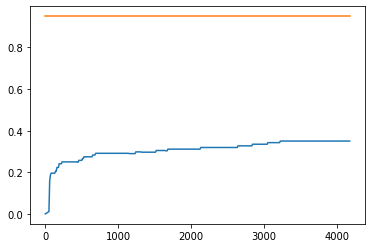

In [35]:
plt.plot(train_szs,scores)
plt.plot(train_szs, [0.95 for sz in train_szs])

Можно видеть, что для достижения лучшего качества на этом датасете дсотаточно обучиться на 300 правильно выбранных примерах.